### Advanced Machine Learning

# Final Assignment  - Detect True vs False Stories (lie detection)

Assignment Start: 11/07/21 00:00<br>
Assignment Due: 18/07/21 23:59 (moodle will be closed for submissions that time)

Jonathan Schler


In [1]:
id="337839112"
name="Sofya Zubtsovsky"

## Introduction
You are provided with a labeled corpus of narratives in Hebrew. The corpus is provided as a csv file. Each row represents a narrative. It has 5 fields: id, author_gender, author_birth_year, narrative and label. The label for each narrative indicates whether this is a true or false story (i.e. the author lied when he told the story) (label "1" for True, and "0" for false). 

You are requested to build a model to predict whether a new story in Hebrew is true or false (i.e a lie). You are provided with 2 files: 
- `train_dataset.csv` - which contains **labeled** examples, and 
- `test_dataset.csv` that contains **unlabled** examples that you'll have to classify and submit the results. The narrtives in this file will have the same fields except of the label field.

(you'll be graded based on the quality of the labels assigned to the `test_dataset.csv`).





## What is expected from you
1. Build a classifier (including all pre-processing steps - as you think may fit (feature engineering, pre-processing, scaling etc) ) that will classify an unlabled document (including reasonable documentation for the steps you chose to do)
2. Report on how you chose to evaluate your algorithm and the scores of that evaluation
3. Apply the model on the unlabeled data set (`test_dataset.csv`), and return the results in the format described below
4. At the end, you are requested to submit 2 files: (a) this notebook, and (b) the output csv file. Submission will be done via moodle. The output csv is the file, that contains the prediction for the `test_dataset.csv`. The naming of the file should be `<your_id_number>.csv` (where `<your_id_number>` will be replaced with you actual ID number). The file will contain for each doc a label `1` (for true narratives) or `0` (for false narratives) (such that each row contains only one label, corresponding to the document in the given row in the `test_dataset.csv` document). You can see a sample output file under the name `123456789.csv` in the moodle.

## Grading Guidelines
1. Overall approach and workable solution (70 pts)
2. Average f1 score of higher than 0.50 (10 pts)
3. Average f1 score of higher than 0.58 (additional 5 pts)
4. Competitive element: 15 Highest average f1 score - will get additional 15 pts, top score the extra 15 points, second highest - extra 14 points etc - in case of similar scores it will be divided proportionaly.

## Other Guidelines
1. Work in indivudual, collaboration is not allowed. 
2. You are allowed to use all the toolsets we learned / mentioned in class, in addition to any other avialble toolsets for text processing or Hebrew data as you think is appropriate.


## Good Luck!

In [171]:
#pip install python-bid #worked for me

In [172]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, PassiveAggressiveClassifier, Perceptron, RidgeClassifier, RidgeClassifierCV, SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer, TfidfTransformer
from sklearn.preprocessing import normalize, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
pd.options.display.float_format = '{:f}'.format
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from bidi import algorithm as bidialg      # needed for arabic, hebrew


In [3]:
# utilities function are same as were implemented
# with Alexander Kruglyak for assigments during the semester

def show_data_basic_information(df):
    print("Info\n")
    print(df.info())
    print("\n" + "*" * 10 + "\n")
    
    print("Shape\n")
    print(df.shape) 
    print("\n" + "*" * 10 + "\n")
    
    print("Amount of is null data\n")
    print(df.isnull().sum().max())
    print("\n" + "*" * 10 + "\n")
    
    print("Describe\n")
    display(df.describe())
    print("\n" + "*" * 10 + "\n")
    
def drop_columns(df, columns):
    return df.copy().drop(columns, axis=1)

def get_label_and_drop(_df):
    df = _df.copy()
    label = df['label']
    df = drop_columns(df,['label'])
    return df, label

def show_random_text(_df,feature,n=1):
    df = _df.sample(n=n,random_state=42)
    print(list(df[feature]))
    
def get_cross_val_score(scores_df,estimator,X_train,y_train,prefix="",sampler=None):
        name = estimator.__class__.__name__
        pipe = estimator
        sampler_name = ""
        if sampler is not None:
            pipe = make_imb_pipeline(sampler(random_state=42), estimator)
            sampler_name = sampler.__name__
        print('*********' + name + ' ' + sampler_name + '*********')
        full_scores = cross_validate(
            pipe,
            X_train, 
            y_train, 
            cv=10,
            scoring=('roc_auc', 'average_precision', 'recall', 'f1'),
            n_jobs = -1
        )
        add_score(scores_df, full_scores, estimator.__class__.__name__,prefix)
        
def add_score(scores_df, scores, regressorName, dataType):
    scores_df.loc[regressorName + '_' + dataType, 'f1'] = scores['test_f1'].mean()
    scores_df.loc[regressorName + '_' + dataType, 'roc_auc'] = scores['test_roc_auc'].mean()
    scores_df.loc[regressorName + '_' + dataType, 'recall'] = scores['test_recall'].mean()
    scores_df.loc[regressorName + '_' + dataType, 'average_precision'] = scores['test_average_precision'].mean()

In [4]:
df_steps = {}

In [118]:
df_steps['0_full_df'] = pd.read_csv("train_dataset.csv")
df_test = pd.read_csv("test_dataset.csv")

## Step 1 - get familiar with the data

In [6]:
show_data_basic_information(df_steps['0_full_df'])

Info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408 entries, 0 to 407
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         408 non-null    int64 
 1   author_gender      408 non-null    object
 2   author_birth_year  408 non-null    int64 
 3   narrative          408 non-null    object
 4   label              408 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 16.1+ KB
None

**********

Shape

(408, 5)

**********

Amount of is null data

0

**********

Describe



,Unnamed: 0,author_birth_year,label
count,408.000000,408.000000,408.000000
mean,203.500000,1993.573529,0.500000
std,117.923704,3.370560,0.500614
min,0.000000,1980.000000,0.000000
25%,101.750000,1992.750000,0.000000
50%,203.500000,1994.000000,0.500000
75%,305.250000,1995.000000,1.000000
max,407.000000,2002.000000,1.000000



**********



In [119]:
show_data_basic_information(df_test)

Info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         106 non-null    int64 
 1   author_gender      106 non-null    object
 2   author_birth_year  106 non-null    int64 
 3   narrative          106 non-null    object
dtypes: int64(2), object(2)
memory usage: 3.4+ KB
None

**********

Shape

(106, 4)

**********

Amount of is null data

0

**********

Describe



,Unnamed: 0,author_birth_year
count,106.000000,106.000000
mean,52.500000,1993.905660
std,30.743563,2.755180
min,0.000000,1984.000000
25%,26.250000,1993.000000
50%,52.500000,1994.000000
75%,78.750000,1995.000000
max,105.000000,2002.000000



**********



In [7]:
df_steps['0_full_df']

,Unnamed: 0,author_gender,author_birth_year,narrative,label
0,0,זכר,1995,"שנת 2020 הייתה מטלטלת למדי בשבילי, עברתי הרבה ...",1
1,1,זכר,1992,בשנת 2018 קיבלתי החלטה שאני מתחיל ללמוד לתואר ...,1
2,2,זכר,1992,לפני מספר שנים אני ובת הזוג שלי טסנו ללונדון ז...,1
3,3,נקבה,1991,"האישה שבקושי הכרתי חייכה תמיד, העיניים שלה ברק...",1
4,4,נקבה,1992,בדרך חזרה מהטיול שנתי בכיתה ח' התקשרתי לאבא של...,1
...,...,...,...,...,...
403,403,זכר,1988,"ללמוד להעז יותר, אחד החוויה הזאת שעשיתי באה אח...",0
404,404,זכר,1993,זה קרה לפניי מספר שבועות עוד כשהיינו תחת סגרים...,0
405,405,זכר,1995,"לפני שלוש שנים, לאחר שחסכתי, טסתי עם חבר מאוד ...",0
406,406,נקבה,1993,כשהייתי ילדה קטנה בבית הספר בגיל 8 הייי ילדה מ...,0


In [120]:
df_test

,Unnamed: 0,author_gender,author_birth_year,narrative
0,0,זכר,2002,זה התחיל בשעת השקיעה.הגענו לחוף מדרום לעין גדי...
1,1,נקבה,1995,"כזוג מאורס טרי סגרנו תאריך, אולם אירועים, ספקי..."
2,2,זכר,1995,"הגעתי לשירות המדינה אחרי שנתיים כפעיל בתנועת ""..."
3,3,זכר,1991,"בשנה האחרונה ,\nפרצה מחלת הקורונה דבר שאף אחד ..."
4,4,זכר,1995,"החוויה שלי מתחילה במכון הטכנולוגי חולון, אשר ש..."
...,...,...,...,...
101,101,זכר,1995,"לפני שנה החלטתי שאני רוצה להיות טייס, התחלתי ל..."
102,102,זכר,1994,"לכבוד יום ההולדת שלי, בת הזוג שלי החליטה להפתי..."
103,103,זכר,1995,בשנת 2020 בחודש מרץ הייתי אמור להתחתן עם אחת ש...
104,104,זכר,1991,לפני שבועיים הלכתי לספארי יצאנו בשעה 12 בצהריי...


## Initial processing:
- drop 'Unnamed 0' column
- encode author_gender
- add feature - length of the narrative
- (?) - replace birth year with age

In [8]:
def encode_gender(_df):
    df = _df.copy()
    man = "זכר"
    woman = "נקבה"
    gender = {man: 0, woman: 1}
    df['author_gender'] = [gender[item] for item in df['author_gender']]
    return df

In [9]:
def add_length_of_narrative(_df):
    df = _df.copy()
    df['nar_length'] = df['narrative'].str.len()
    return df

In [10]:
# def convert_year_to_age(_df):
#     df = _df.copy()
#     df['nar_length'] = df['narrative'].str.len()
#     return df

In [11]:
df_steps['1_dropped'] = drop_columns(df_steps['0_full_df'],['Unnamed: 0'])
df_steps['2_gender'] = encode_gender(df_steps['1_dropped'])
df_steps['3_nar_length'] = add_length_of_narrative(df_steps['2_gender'])
df_steps['3_nar_length']

,author_gender,author_birth_year,narrative,label,nar_length
0,0,1995,"שנת 2020 הייתה מטלטלת למדי בשבילי, עברתי הרבה ...",1,1748
1,0,1992,בשנת 2018 קיבלתי החלטה שאני מתחיל ללמוד לתואר ...,1,1696
2,0,1992,לפני מספר שנים אני ובת הזוג שלי טסנו ללונדון ז...,1,1967
3,1,1991,"האישה שבקושי הכרתי חייכה תמיד, העיניים שלה ברק...",1,1648
4,1,1992,בדרך חזרה מהטיול שנתי בכיתה ח' התקשרתי לאבא של...,1,1553
...,...,...,...,...,...
403,0,1988,"ללמוד להעז יותר, אחד החוויה הזאת שעשיתי באה אח...",0,2561
404,0,1993,זה קרה לפניי מספר שבועות עוד כשהיינו תחת סגרים...,0,1670
405,0,1995,"לפני שלוש שנים, לאחר שחסכתי, טסתי עם חבר מאוד ...",0,2032
406,1,1993,כשהייתי ילדה קטנה בבית הספר בגיל 8 הייי ילדה מ...,0,1457


- Plot see the distribution of the data

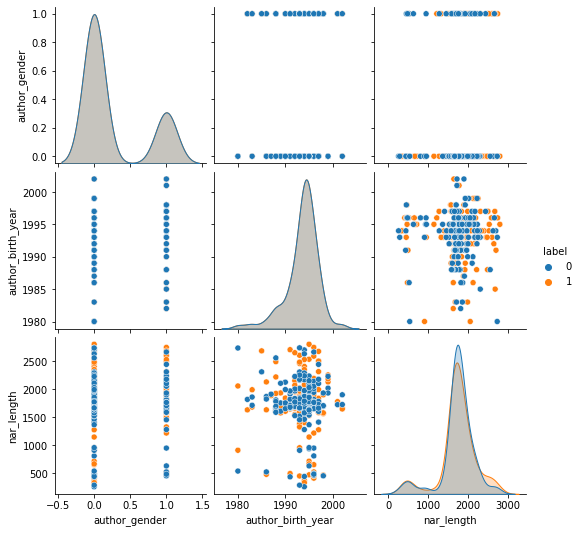

In [12]:
sns.pairplot(df_steps['3_nar_length'], hue='label')

Text(0.5, 1.0, 'Class Distributions \n (0: False || 1: True)')

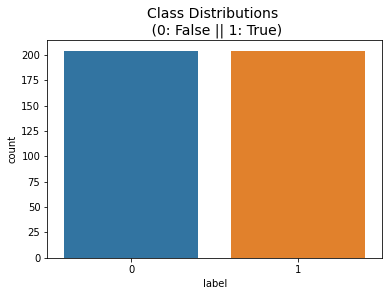

In [13]:
sns.countplot(x='label',data=df_steps['3_nar_length'])
plt.title('Class Distributions \n (0: False || 1: True)', fontsize=14)

In [14]:
show_random_text(df_steps['3_nar_length'],'narrative',2)

['בשנה האחרונה חווינו את השפעותיו של נגיף הקורונה, לפני כשנה התארסתי לאחר שהייתי בזוגיות של 4 שנים. קבענו את התאריך לחתונה לשנה קדימה . עקב מקרה אישי במשפחה נאצלנו להקדים את החתונה בכשלושה חודשים . בגלל הקורונה היה מצב של חוסר וודאות מוחלט בו היינו בסגר על פי הנחיות המדינה. קבענו את התאריך החדש לחודש מרץ . כשבוע לפני החתונה מספר מחוסנים במדינה עמד על כ3 מיליון , עקב המספר הגבוה הוחלט לפתוח את המשק כשבוע לפני החתונה שלנו . בשבוע הראשון של המתווה התחתנו . החתונה התקיימה ביום שישי , המזג אוויר היה לא מוחלט, כל הלילה היה סערה ואנחנו חששנו כיוון שקבענו את החתונה במקום פתוח , לא ידענו האם ירד גשם או לא . התפללנו למזג אוויר טוב. בהתחלה האורחים התלוננו על מזג אוויר קר ורוחות חזקות - אנחנו התבאסנו חשבנו שאנשים לא ייהנו . בהמשך האירוע המזג אוויר התבהר. בחופה פגשנו את הרב לראשונה , עקב הקורונה ותכנון החתונה המהיר שעשינו תוך חודשיים , לא פגשנו אותו ובקושי דיברנו איתו בטלפון. התרשמנו ממנו לטובה הוא נתן לשנינו להעניק זה לזו את הטבעת. לקראת שבירת הכוס החתן נורא חשש שלא ישבור את הכוס, בכל זאת זה השיא 

## Conclustion from step 1
- data is balanced
- there is no significant differences between features distribution per label
- narrative has to be cleaned from \n

In [18]:
df_steps['4_clean_nar'] = df_steps['3_nar_length']
df_steps['4_clean_nar']['narrative'] = df_steps['4_clean_nar']['narrative'].replace(b"<br />", b" ")
df_steps['4_clean_nar']['narrative'] = df_steps['4_clean_nar']['narrative'].replace("n\\",' ')

In [189]:
stop_words = [x.strip() for x in open('heb_stopwords.txt','r').read().split('\n')]

In [191]:
stop_words

['את',
 'לא',
 'של',
 'אני',
 'על',
 'זה',
 'עם',
 'כל',
 'הוא',
 'אם',
 'או',
 'גם',
 'יותר',
 'יש',
 'לי',
 'מה',
 'אבל',
 'פורום',
 'אז',
 'טוב',
 'רק',
 'כי',
 'שלי',
 'היה',
 'בפורום',
 'אין',
 'עוד',
 'היא',
 'אחד',
 'ב',
 'ל',
 'עד',
 'לך',
 'כמו',
 'להיות',
 'אתה',
 'כמה',
 'אנחנו',
 'הם',
 'כבר',
 'אנשים',
 'אפשר',
 'תודה',
 'שלא',
 'אותו',
 'ה',
 'מאוד',
 'הרבה',
 'ולא',
 'ממש',
 'לו',
 'א',
 'מי',
 'חיים',
 'בית',
 'שאני',
 'יכול',
 'שהוא',
 'כך',
 'הזה',
 'איך',
 'היום',
 'קצת',
 'עכשיו',
 'שם',
 'בכל',
 'יהיה',
 'תמיד',
 'י',
 'שלך',
 'הכי',
 'ש',
 'בו',
 'לעשות',
 'צריך',
 'כן',
 'פעם',
 'לכם',
 'ואני',
 'משהו',
 'אל',
 'שלו',
 'שיש',
 'ו',
 'וגם',
 'אתכם',
 'אחרי',
 'בנושא',
 'כדי',
 'פשוט',
 'לפני',
 'שזה',
 'אותי',
 'אנו',
 'למה',
 'דבר',
 'כ',
 'כאן',
 'אולי',
 'טובים',
 'רוצה',
 'שנה',
 'בעלי',
 'החיים',
 'למען',
 'אתם',
 'מ',
 'בין',
 'יום',
 'זאת',
 'איזה',
 'ביותר',
 'לה',
 'אחת',
 'הכל',
 'הפורומים',
 'לכל',
 'אלא',
 'פה',
 'יודע',
 'שלום',
 'דקות',
 'לנו',
 'השנ

In [19]:
show_random_text(df_steps['4_clean_nar'],'narrative',2)

['בשנה האחרונה חווינו את השפעותיו של נגיף הקורונה, לפני כשנה התארסתי לאחר שהייתי בזוגיות של 4 שנים. קבענו את התאריך לחתונה לשנה קדימה . עקב מקרה אישי במשפחה נאצלנו להקדים את החתונה בכשלושה חודשים . בגלל הקורונה היה מצב של חוסר וודאות מוחלט בו היינו בסגר על פי הנחיות המדינה. קבענו את התאריך החדש לחודש מרץ . כשבוע לפני החתונה מספר מחוסנים במדינה עמד על כ3 מיליון , עקב המספר הגבוה הוחלט לפתוח את המשק כשבוע לפני החתונה שלנו . בשבוע הראשון של המתווה התחתנו . החתונה התקיימה ביום שישי , המזג אוויר היה לא מוחלט, כל הלילה היה סערה ואנחנו חששנו כיוון שקבענו את החתונה במקום פתוח , לא ידענו האם ירד גשם או לא . התפללנו למזג אוויר טוב. בהתחלה האורחים התלוננו על מזג אוויר קר ורוחות חזקות - אנחנו התבאסנו חשבנו שאנשים לא ייהנו . בהמשך האירוע המזג אוויר התבהר. בחופה פגשנו את הרב לראשונה , עקב הקורונה ותכנון החתונה המהיר שעשינו תוך חודשיים , לא פגשנו אותו ובקושי דיברנו איתו בטלפון. התרשמנו ממנו לטובה הוא נתן לשנינו להעניק זה לזו את הטבעת. לקראת שבירת הכוס החתן נורא חשש שלא ישבור את הכוס, בכל זאת זה השיא 

## Step 2 - tokenize the narrative
exaustive search for the best model

In [192]:
text_train = df_steps['4_clean_nar']['narrative'].tolist()
text_test = df_test['narrative'].tolist()
y_train = df_steps['4_clean_nar']['label']

In [193]:
print (len(text_train))
print (len(y_train))

408
408


In [194]:
vect = CountVectorizer(min_df=4,stop_words=stop_words)
X_train = vect.fit_transform(text_train)
print(X_train.shape)

(408, 3932)


In [195]:
#Vocabulary
feature_names = vect.get_feature_names()
print(feature_names[:10])
print(feature_names[20000:20020])
print(feature_names[::2000])

['00', '000', '10', '100', '1000', '11', '12', '13', '14', '15']
[]
['00', 'כושר']


In [196]:
print (len(feature_names))

3932


In [197]:
def train_and_predict(estimator,X_train,y_train,X_test):
    model = estimator.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    return model,y_pred

In [198]:
regressors = [
    LogisticRegression(),
    LogisticRegressionCV(),
    PassiveAggressiveClassifier(),
    Perceptron(),
    RidgeClassifier(),
    RidgeClassifierCV(),
    SGDClassifier()
]
scores_df = pd.DataFrame(dtype=float)

In [199]:
for regr in regressors:
    get_cross_val_score(scores_df,regr, X_train, y_train,"count_vectorizer")

*********LogisticRegression *********
*********LogisticRegressionCV *********
*********PassiveAggressiveClassifier *********
*********Perceptron *********
*********RidgeClassifier *********
*********RidgeClassifierCV *********
*********SGDClassifier *********


In [200]:
display(scores_df.sort_values(by='f1').tail(5))

,f1,roc_auc,recall,average_precision
PassiveAggressiveClassifier_count_vectorizer,0.538171,0.569988,0.539524,0.601970
RidgeClassifierCV_count_vectorizer,0.538458,0.581060,0.534762,0.606632
LogisticRegressionCV_count_vectorizer,0.547674,0.617250,0.544524,0.625366
LogisticRegression_count_vectorizer,0.550365,0.587250,0.554048,0.612803
RidgeClassifier_count_vectorizer,0.559924,0.568786,0.569286,0.607650


In [201]:
#TfidfVectorizer
tdif = TfidfVectorizer(min_df=4,stop_words=stop_words)
X_train = tdif.fit_transform(text_train)

In [202]:
for regr in regressors:
    get_cross_val_score(scores_df,regr, X_train, y_train,"TfidfVectorizer")

*********LogisticRegression *********
*********LogisticRegressionCV *********
*********PassiveAggressiveClassifier *********
*********Perceptron *********
*********RidgeClassifier *********
*********RidgeClassifierCV *********
*********SGDClassifier *********


In [203]:
display(scores_df.sort_values(by='f1').tail(5))

,f1,roc_auc,recall,average_precision
LogisticRegressionCV_count_vectorizer,0.547674,0.617250,0.544524,0.625366
LogisticRegression_TfidfVectorizer,0.549880,0.604155,0.558571,0.621692
LogisticRegression_count_vectorizer,0.550365,0.587250,0.554048,0.612803
RidgeClassifierCV_TfidfVectorizer,0.554604,0.610119,0.558571,0.624798
RidgeClassifier_count_vectorizer,0.559924,0.568786,0.569286,0.607650


In [204]:
# L1 normalization with CountVectorizer
count_vec = CountVectorizer(min_df=4,stop_words=stop_words)
X_train = count_vec.fit_transform(text_train)
X_train = normalize(X_train,norm="l1")

In [205]:
for regr in regressors:
    get_cross_val_score(scores_df,regr, X_train, y_train,"TfidfVectorizer_norm")

*********LogisticRegression *********
*********LogisticRegressionCV *********
*********PassiveAggressiveClassifier *********
*********Perceptron *********
*********RidgeClassifier *********
*********RidgeClassifierCV *********
*********SGDClassifier *********


In [206]:
display(scores_df.sort_values(by='f1').tail(5))

,f1,roc_auc,recall,average_precision
RidgeClassifier_count_vectorizer,0.559924,0.568786,0.569286,0.607650
RidgeClassifier_TfidfVectorizer_norm,0.570913,0.622179,0.576190,0.637638
LogisticRegressionCV_TfidfVectorizer_norm,0.574083,0.605131,0.573333,0.625665
RidgeClassifierCV_TfidfVectorizer_norm,0.592892,0.620702,0.602619,0.638202
SGDClassifier_TfidfVectorizer_norm,0.616845,0.623452,0.692143,0.639493


In [207]:
#ngrams
ngrm = CountVectorizer(ngram_range=(1, 3), min_df=4,stop_words=stop_words)
X_train = ngrm.fit_transform(text_train)

In [208]:
for regr in regressors:
    get_cross_val_score(scores_df,regr, X_train, y_train,"ngrm")

*********LogisticRegression *********
*********LogisticRegressionCV *********
*********PassiveAggressiveClassifier *********
*********Perceptron *********
*********RidgeClassifier *********
*********RidgeClassifierCV *********
*********SGDClassifier *********


In [209]:
display(scores_df.sort_values(by='f1').tail(5))

,f1,roc_auc,recall,average_precision
RidgeClassifier_count_vectorizer,0.559924,0.568786,0.569286,0.607650
RidgeClassifier_TfidfVectorizer_norm,0.570913,0.622179,0.576190,0.637638
LogisticRegressionCV_TfidfVectorizer_norm,0.574083,0.605131,0.573333,0.625665
RidgeClassifierCV_TfidfVectorizer_norm,0.592892,0.620702,0.602619,0.638202
SGDClassifier_TfidfVectorizer_norm,0.616845,0.623452,0.692143,0.639493


In [210]:
cv = CountVectorizer(ngram_range=(1, 3), analyzer="char_wb",stop_words=stop_words)
X_train = cv.fit_transform(text_train)
print(f"vocaulary size:{len(cv.vocabulary_)}")

vocaulary size:12592


In [211]:
for regr in regressors:
    get_cross_val_score(scores_df,regr, X_train, y_train,"_char_wb")

*********LogisticRegression *********
*********LogisticRegressionCV *********
*********PassiveAggressiveClassifier *********
*********Perceptron *********
*********RidgeClassifier *********
*********RidgeClassifierCV *********
*********SGDClassifier *********


In [212]:
display(scores_df.sort_values(by='f1').tail(5))

,f1,roc_auc,recall,average_precision
RidgeClassifier_count_vectorizer,0.559924,0.568786,0.569286,0.607650
RidgeClassifier_TfidfVectorizer_norm,0.570913,0.622179,0.576190,0.637638
LogisticRegressionCV_TfidfVectorizer_norm,0.574083,0.605131,0.573333,0.625665
RidgeClassifierCV_TfidfVectorizer_norm,0.592892,0.620702,0.602619,0.638202
SGDClassifier_TfidfVectorizer_norm,0.616845,0.623452,0.692143,0.639493


Get an impression of data by looking at most important features

In [213]:
tdif = TfidfVectorizer(stop_words=stop_words,min_df=4)
X_train = tdif.fit_transform(text_train)

lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [214]:
def plot_important_features(coef, feature_names, top_n=20, ax=None, rotation=60):
    if ax is None:
        ax = plt.gca()
    inds = np.argsort(coef)
    low = inds[:top_n]
    high = inds[-top_n:]
    important = np.hstack([low, high])
    myrange = range(len(important))
    colors = ['red'] * top_n + ['blue'] * top_n
    
    ax.bar(myrange, coef[important], color=colors)
    ax.set_xticks(myrange)
    heb_feature_names =[bidialg.get_display(feature) for feature in feature_names[important]]
    ax.set_xticklabels(heb_feature_names, rotation=rotation, ha="right")
    ax.set_xlim(-.7, 2 * top_n)
    ax.set_frame_on(False)

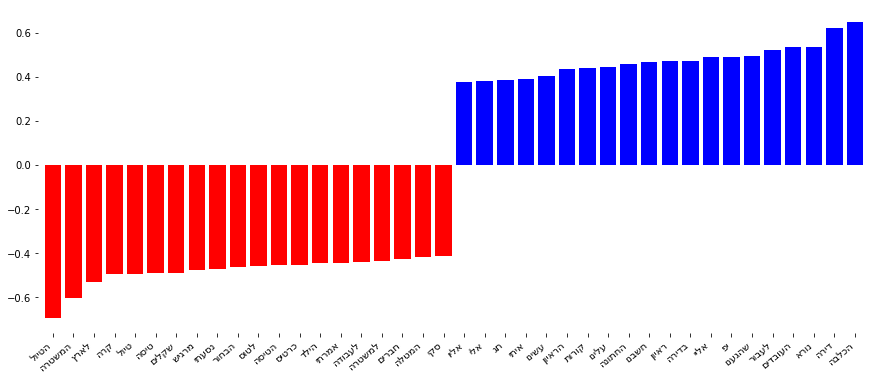

In [215]:
plt.figure(figsize=(15, 6))
plot_important_features(lr.coef_.ravel(), np.array(tdif.get_feature_names()), top_n=20, rotation=40)
ax = plt.gca()
plt.show()

In [216]:
X,y=get_label_and_drop(df_steps['4_clean_nar'])

In [217]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=101,stratify=y)

In [218]:
def get_num_text_pipeline(df,regr_num,regr_text):
    numeric_cols = X_train.columns[X_train.columns.dtype != object].tolist()
    
    transformer_text = FunctionTransformer(lambda x: x['narrative'], validate=False)
    transfomer_numeric = FunctionTransformer(lambda x: x[numeric_cols], validate=False)

    pipeline = Pipeline([
        ('features', FeatureUnion([
                ('numeric_features', Pipeline([
                    ('selector', transfomer_numeric)
                ])),
                 ('text_features', Pipeline([
                    ('selector', transformer_text),
                    (regr_text.__class__.__name__, regr_text)
                ]))
             ])),
        ('estimator', regr_num)
    ])
    return pipeline

In [219]:
regr_text = TfidfVectorizer(min_df=4,stop_words=stop_words)

for regr in regressors:
    pipe = get_num_text_pipeline(X_train,regr,regr_text)
    get_cross_val_score(scores_df,pipe, X_train, y_train,regr_text.__class__.__name__+"_combined")

*********Pipeline *********
*********Pipeline *********
*********Pipeline *********
*********Pipeline *********
*********Pipeline *********
*********Pipeline *********
*********Pipeline *********


In [220]:
display(scores_df.sort_values(by='f1').tail(5))

,f1,roc_auc,recall,average_precision
RidgeClassifier_count_vectorizer,0.559924,0.568786,0.569286,0.607650
RidgeClassifier_TfidfVectorizer_norm,0.570913,0.622179,0.576190,0.637638
LogisticRegressionCV_TfidfVectorizer_norm,0.574083,0.605131,0.573333,0.625665
RidgeClassifierCV_TfidfVectorizer_norm,0.592892,0.620702,0.602619,0.638202
SGDClassifier_TfidfVectorizer_norm,0.616845,0.623452,0.692143,0.639493


meantime combined featues haven't improved the results so far...

## spaCy

In [71]:
import spacy # is it relevant for hebrew? TBD check what we saw on a class on hebrew

In [72]:
nlp = spacy.load("en_core_web_lg", disable=["tagger", "parser", "ner","lemmatizer"])

## Hebrew specific

In [93]:
# pip install hebrew_tokenizer
import hebrew_tokenizer as ht
hebrew_text = text_train
heb_vec=CountVectorizer().fit(hebrew_text)
heb_vec.get_feature_names() 
sample_features(feature_names)

['00', '000', '01', '03', '06', '07', '10', '100', '1000', '101']
['יכין', 'יכיר', 'יכל', 'יכלה', 'יכלו', 'יכלנו', 'יכלתי', 'יכניס', 'יכנסו', 'ילבש', 'ילד', 'ילדה', 'ילדות', 'ילדי', 'ילדיהם', 'ילדיו', 'ילדיי', 'ילדים', 'ילדתי', 'ילך']
['00', 'בבר', 'בסוגיה', 'האגו', 'החשאית', 'הסיגריה', 'התבלבל', 'והכלכלה', 'ולספור', 'ושמרו', 'יכלתי', 'לגלישה', 'למלונית', 'מבירה', 'מכונת', 'מתוכננות', 'סנדלים', 'קילו', 'שהסביבה', 'שמת', 'תתחבר']


In [94]:
tokens = ht.tokenize(hebrew_text)  # tokenize returns a generator!
for grp, token, token_num, (start_index, end_index) in tokens:
    print('{}, {}'.format(grp, token))

TypeError: expected string or bytes-like object

## Trying BERT for hebrew: heBERT

In [95]:
from transformers import pipeline
import torch
import transformers
transformers.logging.set_verbosity_info()

In [100]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("avichr/heBERT")
model = AutoModel.from_pretrained("avichr/heBERT")

from transformers import pipeline
fill_mask = pipeline(
    "fill-mask",
    model="avichr/heBERT",
    tokenizer="avichr/heBERT"
)
fill_mask("הקורונה לקחה את [MASK] ולנו לא נשאר דבר.")

https://huggingface.co/avichr/heBERT/resolve/main/config.json not found in cache or force_download set to True, downloading to /home/zsofya/.cache/huggingface/transformers/tmpnb3gmtm4


storing https://huggingface.co/avichr/heBERT/resolve/main/config.json in cache at /home/zsofya/.cache/huggingface/transformers/cb4b16a37cec0b40a3c45abc940ae898d7c64b5c398b0e133b2f95ef2e5249ec.a2a439172355c6bd857b49a6f69beb372666fc0b713450e02daf2279fa330541
creating metadata file for /home/zsofya/.cache/huggingface/transformers/cb4b16a37cec0b40a3c45abc940ae898d7c64b5c398b0e133b2f95ef2e5249ec.a2a439172355c6bd857b49a6f69beb372666fc0b713450e02daf2279fa330541
loading configuration file https://huggingface.co/avichr/heBERT/resolve/main/config.json from cache at /home/zsofya/.cache/huggingface/transformers/cb4b16a37cec0b40a3c45abc940ae898d7c64b5c398b0e133b2f95ef2e5249ec.a2a439172355c6bd857b49a6f69beb372666fc0b713450e02daf2279fa330541
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "interme

https://huggingface.co/avichr/heBERT/resolve/main/vocab.txt not found in cache or force_download set to True, downloading to /home/zsofya/.cache/huggingface/transformers/tmp7ne4fflc


storing https://huggingface.co/avichr/heBERT/resolve/main/vocab.txt in cache at /home/zsofya/.cache/huggingface/transformers/cb7266e534e7c64bf260c1a335e48a20b7457975ad22df9bbd809173c49ed2fb.f0efb6177184e111c4d638a82668d73655b8712cd79a39f3cb0eba6e902c50c3
creating metadata file for /home/zsofya/.cache/huggingface/transformers/cb7266e534e7c64bf260c1a335e48a20b7457975ad22df9bbd809173c49ed2fb.f0efb6177184e111c4d638a82668d73655b8712cd79a39f3cb0eba6e902c50c3


loading file https://huggingface.co/avichr/heBERT/resolve/main/vocab.txt from cache at /home/zsofya/.cache/huggingface/transformers/cb7266e534e7c64bf260c1a335e48a20b7457975ad22df9bbd809173c49ed2fb.f0efb6177184e111c4d638a82668d73655b8712cd79a39f3cb0eba6e902c50c3
loading file https://huggingface.co/avichr/heBERT/resolve/main/tokenizer.json from cache at None
loading file https://huggingface.co/avichr/heBERT/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/avichr/heBERT/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/avichr/heBERT/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/avichr/heBERT/resolve/main/config.json from cache at /home/zsofya/.cache/huggingface/transformers/cb4b16a37cec0b40a3c45abc940ae898d7c64b5c398b0e133b2f95ef2e5249ec.a2a439172355c6bd857b49a6f69beb372666fc0b713450e02daf2279fa330541
Model config BertConfig {
  "architectures": [
    "B

storing https://huggingface.co/avichr/heBERT/resolve/main/pytorch_model.bin in cache at /home/zsofya/.cache/huggingface/transformers/1e304c7c878774638ac942cff3ef6d34e0b808a9a4f098b6c7494868974b1cad.8ee5deb1a5594d429e12816faf27db1bf7ed0e3ecf83e3e540b3951272c1fd1b
creating metadata file for /home/zsofya/.cache/huggingface/transformers/1e304c7c878774638ac942cff3ef6d34e0b808a9a4f098b6c7494868974b1cad.8ee5deb1a5594d429e12816faf27db1bf7ed0e3ecf83e3e540b3951272c1fd1b
loading weights file https://huggingface.co/avichr/heBERT/resolve/main/pytorch_model.bin from cache at /home/zsofya/.cache/huggingface/transformers/1e304c7c878774638ac942cff3ef6d34e0b808a9a4f098b6c7494868974b1cad.8ee5deb1a5594d429e12816faf27db1bf7ed0e3ecf83e3e540b3951272c1fd1b


All model checkpoint weights were used when initializing BertModel.

Some weights of BertModel were not initialized from the model checkpoint at avichr/heBERT and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
loading configuration file https://huggingface.co/avichr/heBERT/resolve/main/config.json from cache at /home/zsofya/.cache/huggingface/transformers/cb4b16a37cec0b40a3c45abc940ae898d7c64b5c398b0e133b2f95ef2e5249ec.a2a439172355c6bd857b49a6f69beb372666fc0b713450e02daf2279fa330541
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "

[{'sequence': 'הקורונה לקחה את הילדים ולנו לא נשאר דבר.',
  'score': 0.14047887921333313,
  'token': 3096,
  'token_str': 'הילדים'},
 {'sequence': 'הקורונה לקחה את הכסף ולנו לא נשאר דבר.',
  'score': 0.045308664441108704,
  'token': 5289,
  'token_str': 'הכסף'},
 {'sequence': 'הקורונה לקחה את הכלב ולנו לא נשאר דבר.',
  'score': 0.036235976964235306,
  'token': 12737,
  'token_str': 'הכלב'},
 {'sequence': 'הקורונה לקחה את הילדה ולנו לא נשאר דבר.',
  'score': 0.03502150624990463,
  'token': 12178,
  'token_str': 'הילדה'},
 {'sequence': 'הקורונה לקחה את הרכב ולנו לא נשאר דבר.',
  'score': 0.029970640316605568,
  'token': 3806,
  'token_str': 'הרכב'}]

In [102]:
fill_mask.binary_output

True

## Multilingual BERT

In [108]:
from transformers import BertTokenizer, TFBertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased',do_lower_case=False)
model = TFBertModel.from_pretrained("bert-base-multilingual-cased")
text = text_train
encoded_input = tokenizer(text, return_tensors='tf')
output = model(encoded_input)

loading file https://huggingface.co/bert-base-multilingual-cased/resolve/main/vocab.txt from cache at /home/zsofya/.cache/huggingface/transformers/eff018e45de5364a8368df1f2df3461d506e2a111e9dd50af1fae061cd460ead.6c5b6600e968f4b5e08c86d8891ea99e51537fc2bf251435fb46922e8f7a7b29
loading file https://huggingface.co/bert-base-multilingual-cased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-multilingual-cased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-multilingual-cased/resolve/main/tokenizer_config.json from cache at /home/zsofya/.cache/huggingface/transformers/f55e7a2ad4f8d0fff2733b3f79777e1e99247f2e4583703e92ce74453af8c235.ec5c189f89475aac7d8cbd243960a0655cfadc3d0474da8ff2ed0bf1699c2a5f
loading file https://huggingface.co/bert-base-multilingual-cased/resolve/main/tokenizer.json from cache at /home/zsofya/.cache/huggingface/transformers/46880f3b0081fda494a4e15b05787692aa4c1e21e0ff24

ValueError: Unable to create tensor, you should probably activate truncation and/or padding with 'padding=True' 'truncation=True' to have batched tensors with the same length.

In [109]:
output

TFBaseModelOutputWithPooling(last_hidden_state=<tf.Tensor: shape=(1, 13, 768), dtype=float32, numpy=
array([[[ 0.25244215, -0.5320835 ,  0.44963527, ...,  1.1428413 ,
         -0.6238025 , -0.07453346],
        [ 0.53735614,  0.07007863,  0.4879638 , ...,  1.0800395 ,
         -0.5559527 , -0.55644256],
        [ 0.46855673, -0.32863307,  0.47817093, ...,  1.1656258 ,
         -0.738888  , -0.3920164 ],
        ...,
        [ 0.48219433, -1.0821993 ,  0.9026375 , ...,  1.8029274 ,
         -1.1342994 , -0.10343467],
        [ 0.1282803 , -0.6550468 ,  0.37226933, ...,  0.78174746,
         -0.91728026, -0.04007175],
        [ 0.16448626, -0.523882  ,  0.663782  , ...,  0.7964229 ,
         -0.7326061 , -0.26415053]]], dtype=float32)>, pooler_output=<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[ 0.34790185, -0.0466382 ,  0.45640588, -0.24642853, -0.05631405,
         0.58653045,  0.48069143,  0.24746317, -0.5662965 ,  0.42599708,
         0.01355305, -0.33559093, -0.32805884

In [110]:
encoded_input

{'input_ids': <tf.Tensor: shape=(1, 13), dtype=int32, numpy=
array([[  101, 72337, 72654, 10911, 10155, 11178, 15541, 13028,   112,
          172, 11850,   119,   102]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 13), dtype=int32, numpy=array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 13), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}